<a href="https://colab.research.google.com/github/ramanakshay/Optimal-Transport/blob/main/notebooks/multi_marginal_ot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Marginal Optimal Transport

## Import Libraries

In [1]:
!pip install pot  # Pip Installs Packages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 664 kB 4.3 MB/s 


In [2]:
user = 'ramanakshay'
repo = 'Optimal-Transport'

url = f"git+https://github.com/{user}/{repo}.git"
!pip install --upgrade {url}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ramanakshay/Optimal-Transport.git to /tmp/pip-req-build-hcax9c6l
  Running command git clone -q https://github.com/ramanakshay/Optimal-Transport.git /tmp/pip-req-build-hcax9c6l
  Created wheel for utils: filename=utils-0.1.0-py3-none-any.whl size=3084 sha256=7c1892d2184c0a83d782dc3fc282d6fe909cfb3cb6be7c172bf53b52594aa2d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-hred3p6f/wheels/83/c1/b0/8b4aae55c1a6c852e5e98d2e522e0c76c069f92e4d3885455f
Successfully built utils


In [3]:
import numpy as np 

import matplotlib.pyplot as plt # plotting

import ot  # ot
import ot.plot
from prettytable import PrettyTable

import time # measure time
from numpy import random

from tqdm import tqdm #progress bar
from IPython.display import clear_output

In [4]:
from utils.plot import plot_matrix,plot_2d_map
from utils.dist import find_cost_tensor

## Sinkhorn Solver Class

In [5]:
class SinkhornSolver(object):
  def __init__(self,A,C):
    self.A = A
    self.C = C
    self.n = A.shape[0]
    self.size = A.shape[1]
  
  def initialise(self,kind):
    if (kind == "ones"):
      return np.ones((self.n,self.size))
    elif (kind == "random"):
      return random.rand(self.n,self.size)
    else:
      raise ValueError("Invalid Argument: " + kind + " is not a valid type.")

#-----------------------------HELPER FUNCTIONS---------------------------------#
  def multiply(self,P,U,i):
    shape = [1]*self.n
    shape[i] = self.size
    shape = tuple(shape)
    temp = U[i].reshape(shape)
    return P * temp

  def divide(self,P,U,i):
    shape = [1]*self.n
    shape[i] = self.size
    shape = tuple(shape)
    temp = U[i].reshape(shape)
    return P / temp

  def sum_to_vector(self,P,i):
    axes = list(range(n))
    axes.remove(i)
    axes = tuple(axes)
    return np.sum(P,axis = axes)

#-----------------------------GENERIC SINKHORN---------------------------------#

  def generic_sinkhorn(self,epsilon,niter,kind = "ones"):
    U = self.initialise(kind)
    K = np.exp(-self.C/epsilon)
    P = np.copy(K)

    #initialise P
    for i in range(self.n):
      P = self.multiply(P,U,i)
    
    #loop
    for it in tqdm(range(niter)):
      for i in range(self.n):
        P = self.divide(P,U,i)
        U[i] = self.A[i] / self.sum_to_vector(P,i)
        P = self.multiply(P,U,i)
    
    #return coupling
    return P

#--------------------------------AUTO SINKHORN---------------------------------#

  def auto_sinkhorn(self,epsilon,error,kind = "ones"):
    U = self.initialise(kind)
    K = np.exp(-self.C/epsilon)
    P = np.copy(K)

    #initialise P
    for i in range(self.n):
      P = self.multiply(P,U,i)
    
    #loop
    iter = 0
    while(True):
      for i in range(self.n):
        P = self.divide(P,U,i)
        U[i] = self.A[i] / self.sum_to_vector(P,i)
        P = self.multiply(P,U,i)

      #marginal condition
      flag = True
      max_error = -1
      for i in range(self.n):
        if (np.any(abs(self.sum_to_vector(P,i) - self.A[i]) >= error)):
          flag = False
        clear_output(wait = True)
        max_error = max(max_error,np.max(abs(self.sum_to_vector(P,i) - self.A[i])))
      if(flag):
        break

      print("Maximum Error:",max_error)
      print("#Iterations:",iter)
      
      iter += 1

    #return coupling  
    return P

#--------------------------------RANDOM SINKHORN-------------------------------#

  def random_sinkhorn(self,epsilon,error,k = None,kind = "ones"):
    if (k == None):
      k = self.n

    U = self.initialise(kind)
    K = np.exp(-self.C/epsilon)
    P = np.copy(K)

    #initialise P
    for i in range(self.n):
      P = self.multiply(P,U,i)
    
    #loop
    iter = 0
    while(True):
      for i in random.choice(self.n, k, replace=False):
        P = self.divide(P,U,i)
        U[i] = self.A[i] / self.sum_to_vector(P,i)
        P = self.multiply(P,U,i)

      #marginal condition
      flag = True
      max_error = -1
      for i in range(self.n):
        if (np.any(abs(self.sum_to_vector(P,i) - self.A[i]) >= error)):
          flag = False
        clear_output(wait = True)
        max_error = max(max_error,np.max(abs(self.sum_to_vector(P,i) - self.A[i])))
      if(flag):
        break
      
      print("Maximum Error:",max_error)
      print("#Iterations:",iter)

      iter += 1

    #return coupling  
    return P

#------------------------------------------------------------------------------#

## 1D Marginals

### Gaussian Distribution

In [6]:
def gaussian_mix(n,mu,std,scale = None):
  assert len(mu) == len(std)
  if scale == None:
    scale = [1]*len(mu)
  x = np.arange(n, dtype = np.float64)
  h = 0
  for i in range(len(mu)):
    h += np.exp(-(x - mu[i]) ** 2 / (2 * std[i] ** 2))*scale[i]
  return h / h.sum()

In [7]:
# n = 3
# size = 100

# A = np.empty((n,size), float)
# A[0] = gaussian_mix(size,[10,50],[5,15],[2,1])
# A[1] = gaussian_mix(size,[15,60],[2,10],[1.5,1])
# A[2] = gaussian_mix(size,[20,80],[10,5],[1,1])
# #A[3] = gaussian_mix(size,[25,70],[5,10],[1.5,1])

# x = np.array([[i,] for i in range(size)]) # defining the space
# X = np.tile(x.T,(n,1))

In [9]:
n = 3
size = 100

A = np.empty((n,size), float)
A[0]  = A[1] = A[2] = gaussian_mix(size,[50],[10],[1])
# A[1] = gaussian_mix(size,[30],[15],[1])
# A[2] = gaussian_mix(size,[70],[10],[1])
#A[3] = gaussian_mix(size,[25,70],[5,10],[1.5,1])

x = np.array([[i,] for i in range(size)]) # defining the space
X = np.tile(x.T,(n,1))

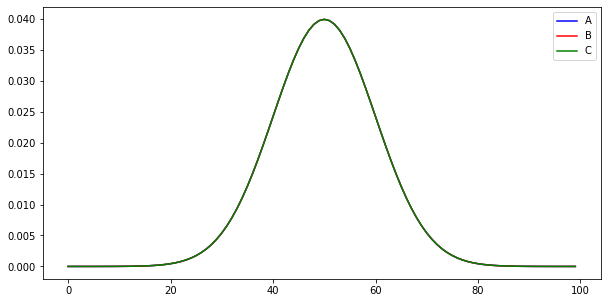

In [10]:
#Plot distributions
plt.figure(figsize=(10, 5))
plt.plot(x, A[0], 'b', label='A')
plt.plot(x, A[1], 'r', label='B')
plt.plot(x, A[2], 'g', label='C')
#plt.plot(x, A[3], 'y', label='D')
plt.legend()
plt.show()

### Cost Tensor

(100, 100, 100)


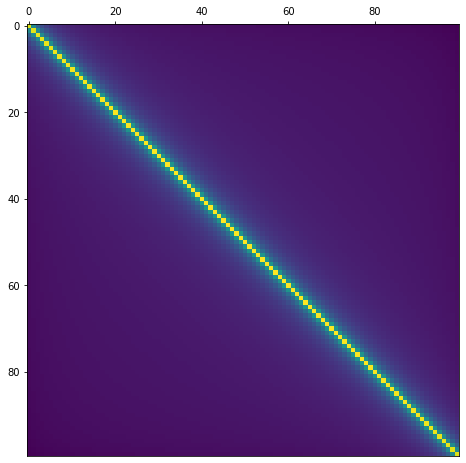

In [11]:
C = find_cost_tensor(X)
Cm = np.sum(C,axis = 2)
print(C.shape)
plot_matrix(Cm,x,x)

## Sinkhorn Algorithms

In [12]:
solver = SinkhornSolver(A,C)

In [19]:
P = solver.auto_sinkhorn(1e-3,1e-6,kind="random")

Maximum Error: 1.0226280717645642e-06
#Iterations: 506


In [15]:
P = solver.generic_sinkhorn(1e-3,1000)

100%|██████████| 1000/1000 [00:16<00:00, 60.41it/s]


9900


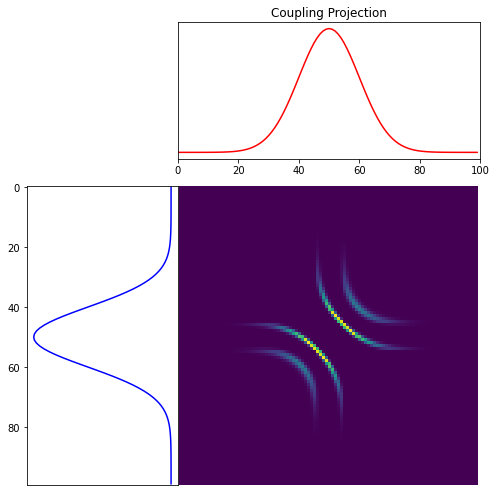

In [17]:
Pm = np.sum(P,axis = 2)

# count = 0
# for i in range(Pm.shape[0]):
#   for j in range(Pm.shape[1]):
#     if Pm[i][j] > 0:
#       count += 1
#     if Pm[i][j] > 1e-5:
#       Pm[i][j] = 1
#     else:
#       Pm[i][j] = 0
# print(count)

plt.figure(figsize=(7, 7))
ot.plot.plot1D_mat(A[0], A[1], Pm, 'Coupling Projection')

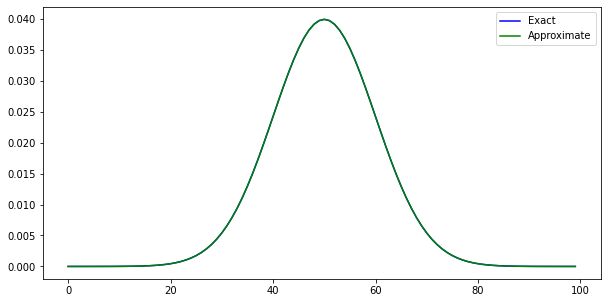

In [18]:
Pv = np.sum(P,axis = (1,2))
plt.figure(figsize=(10, 5))
plt.plot(x, A[0], 'b', label='Exact')
plt.plot(x, Pv, 'g', label='Approximate')
plt.legend()
plt.show()

### OT Total Cost

In [20]:
OT = np.sum(C*P)
print(OT)

0.2215746076094513
